In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from math import dist

image_file = 'pool_lane.png'

In [2]:
def detect_lines(img1, threshold1, threshold2, apertureSize, minLineLength, maxLineGap):
    img = cv2.imread(img1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    edges = cv2.Canny(gray, threshold1, threshold2, apertureSize) # detect edges
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=minLineLength, maxLineGap=maxLineGap) # detect lines
    return lines

line_list = detect_lines(image_file, 30, 50, 3, 150, 200)
#print(line_list)
#print(len(line_list))


In [3]:
#def draw_lines(img2, lines, color):
def draw_lines(img2, lines):
    img = cv2.imread(img2)
    for line in lines:
        x1, y1, x2, y2 = line[0]
        color = (
            random.randint(50, 255),  # Red
            random.randint(50, 255),  # Green
            random.randint(50, 255)   # Blue
        )
        cv2.line(img, (x1, y1), (x2, y2), (color[0], color[1], color[2]), 5)
    return img


# Draw lines and get the result image
#output_img = draw_lines(image_file, line_list, (0, 255, 0))
output_img = draw_lines(image_file, line_list)
print(line_list)

# Convert BGR to RGB for displaying with matplotlib
output_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

[[[2651 1100 3784 1321]]

 [[2543 1027 3809 1182]]

 [[1065 2026 1436 1409]]

 [[1010 2123 1405 1465]]

 [[1010 2121 1422 1434]]

 [[1017 2112 1406 1465]]

 [[2809 1058 3819 1182]]

 [[2652 1100 3782 1319]]

 [[1427 2106 1617 1343]]

 [[2634 1040 3813 1185]]

 [[1006 2134 1397 1483]]

 [[1423 2130 1606 1396]]

 [[2664 1104 3784 1322]]

 [[1425 2107 1618 1333]]

 [[2810 1058 3813 1181]]

 [[3145 1194 3780 1317]]

 [[1440 2040 1628 1288]]]


In [4]:
def get_slopes_intercepts(lines):
    slope_list = []
    x_intercept_list = []
    for line in lines: 
        x1, y1, x2, y2 = line[0]
        if x2 - x1 == 0 or (y2 - y1)/(x2 - x1) == 0:
            slope = float('inf')  # vertical line
            x_intercept = x1      # vertical line: x-intercept is x
            slope_list.append(float(slope))
            x_intercept_list.append(float(x_intercept))
        else:
            slope = (y2 - y1)/(x2 - x1)
            x_intercept = x1 - (y1/slope)
            slope_list.append(float(slope))
            x_intercept_list.append(float(x_intercept))
    return slope_list, x_intercept_list

#print(get_slopes_intercepts(line_list))

In [5]:
def merge_lines(lines, slope_thresh, x_int_thresh, distance_thresh):

    merged = []
    used = set()
    slopes, x_intercepts = get_slopes_intercepts(lines)

    def line_distance(p1, p2):
        return np.linalg.norm(np.array(p1) - np.array(p2))

    for i in range(len(lines)):
        if i in used:
            continue
        x1a, y1a, x2a, y2a = lines[i][0]
        slope_a = slopes[i]
        xint_a = x_intercepts[i]
        endpoints = [(x1a, y1a), (x2a, y2a)]

        for j in range(i + 1, len(lines)):
            if j in used:
                continue
            slope_b = slopes[j]
            xint_b = x_intercepts[j]
            x1b, y1b, x2b, y2b = lines[j][0]

            # Criteria to merge: similar slope & close in x-intercept or endpoint
            if abs(slope_a - slope_b) < slope_thresh:
                xint_close = abs(xint_a - xint_b) < x_int_thresh
                endpt_close = (
                    line_distance((x1a, y1a), (x1b, y1b)) < distance_thresh or
                    line_distance((x1a, y1a), (x2b, y2b)) < distance_thresh or
                    line_distance((x2a, y2a), (x1b, y1b)) < distance_thresh or
                    line_distance((x2a, y2a), (x2b, y2b)) < distance_thresh
                )

                if xint_close or endpt_close:
                    endpoints.extend([(x1b, y1b), (x2b, y2b)])
                    used.add(j)

        # Create a line from furthest two endpoints
        pts = np.array(endpoints)
        dists = np.sum((pts[:, None, :] - pts[None, :, :]) ** 2, axis=-1)
        i1, i2 = np.unravel_index(np.argmax(dists), dists.shape)
        merged.append(np.array([[pts[i1][0], pts[i1][1], pts[i2][0], pts[i2][1]]], dtype=np.int32))
        used.add(i)

    return merged

merged_lines_list = merge_lines(line_list, 0.05, 50, 50)
#plt.imshow(draw_lines(image_file, merged_lines_list))
#print(merged_lines_list)

In [6]:
def detect_lanes(lines, max_slope_diff=0.05, min_midpoint_x_diff=100):
    """
    Detect lanes by matching each line to its closest midpoint pair, ensuring one-use-per-line.

    Args:
        lines (list): List of 1x4 numpy arrays representing lines.
        max_slope_diff (float): Max allowed slope difference to consider lines parallel.
        min_midpoint_x_diff (float): Min horizontal distance between midpoints to consider a lane.

    Returns:
        list: List of lanes, where each lane is a list of 2 lines.
    """
    slopes, _ = get_slopes_intercepts(lines)
    midpoints = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        xm = (x1 + x2) / 2
        ym = (y1 + y2) / 2
        midpoints.append((xm, ym))

    lanes = []
    used = set()

    for i in range(len(lines)):
        if i in used:
            continue
        best_match = None
        best_distance = float('inf')

        for j in range(len(lines)):
            if j == i or j in used:
                continue

            slope1, slope2 = slopes[i], slopes[j]
            xm1, _ = midpoints[i]
            xm2, _ = midpoints[j]

            if abs(slope1 - slope2) < max_slope_diff:
                midpoint_x_diff = abs(xm1 - xm2)

                if midpoint_x_diff > min_midpoint_x_diff and midpoint_x_diff < best_distance:
                    best_distance = midpoint_x_diff
                    best_match = j

        if best_match is not None:
            lanes.append([lines[i], lines[best_match]])
            used.add(i)
            used.add(best_match)

    return lanes




lanes_list = detect_lanes(merged_lines_list, 1000, 1)
#print(lanes_list)
#print(len(lanes_list))
#for x in lanes_list:
#    print(x)

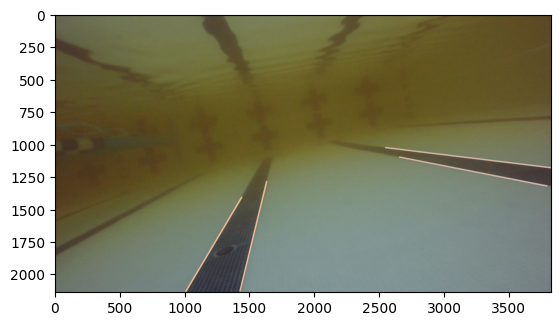

In [7]:

def draw_lanes(img_path, lanes, thickness=10):
    img = cv2.imread(img_path)

    for lane in lanes:
        # Generate a random color for each lane
        color = (
            random.randint(50, 255),  # Red
            random.randint(50, 255),  # Green
            random.randint(50, 255)   # Blue
        )

        for line in lane:
            x1, y1, x2, y2 = line[0]
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    return img


plt.imshow(draw_lanes(image_file, lanes_list))